In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# **AA UTILS**

In [98]:
def if_dataframe_to_numpy(data):
    return data.to_numpy() if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series) else data

def plot_2d(modelo, X, X_train, X_test, y_train, y_test, boundry_function):

    assert X.shape[1] == 2, f"X debe tener solo dos variables de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)
    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    plt.figure()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = np.c_[xx.ravel(), yy.ravel()]
    Z = boundry_function(modelo, Z)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.colorbar()

    plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train, label='Training')
    plt.scatter(X_test[:, 0], X_test[:, 1], marker="+", c=y_test, s=80, label='Testing')
    plt.legend()
    plt.show()

def print_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))

def visualizar_parametros(modelo, mostrar_bias, feature_names=[], target_name='target'):
    parametros = pd.DataFrame(modelo.coef_, columns=feature_names if len(feature_names) > 0 else range(modelo.coef_.shape[1]))

    if mostrar_bias:
        parametros['bias'] = modelo.intercept_

    parametros.T.plot(kind='bar')

    if hasattr(modelo, 'classes_'):
        if len(modelo.classes_) <= 2:
            plt.legend([target_name])
        else:
            plt.legend(list(modelo.classes_))
    else:
        plt.legend([target_name])

    plt.show()

def visualizar_curva_logistica(modelo, X, y, feature_name='target'):

    assert X.shape[1] == 1, f"X debe tener solo una variable de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)

    plt.figure()
    plt.scatter(X, y, c=y, s=50)
    plt.xlabel(feature_name)
    plt.grid()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_graph = np.linspace(x_min, x_max)
    y_graph = modelo.predict_proba(x_graph.reshape(-1, 1))[:, 1]
    plt.plot(x_graph, y_graph)
    plt.show()

def visualizar_frontera_de_desicion_2D(modelo, X, X_train, X_test, y_train, y_test):
    plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict(Z))

def visualizar_funcion_transferencia_2D(modelo, X, X_train, X_test, y_train, y_test):

    if hasattr(modelo, 'predict_proba') and callable(getattr(modelo, 'predict_proba')):
        plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict_proba(Z)[:, 1])
    else:
        raise ValueError("no se puede visualizar funcion de transferencia")

def visualizar_confusion_matrix(real_target, pred_target,
                                classes=[],
                                normalize=False,
                                title='Matriz de confusión',
                                cmap=plt.cm.Blues):

    if (len(classes) == 0):
        classes = [str(i) for i in range(int(max(real_target) + 1))]  # nombres de clases consecutivos

    cm = confusion_matrix(real_target, pred_target)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size=16)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def visualizar_curva_ROC(modelo, X, y):

    assert len(set(y)) <= 2, f"El dataset debe ser binario (hay {len(set(y))}) clases"

    y_score = modelo.predict_proba(X)[:, 1]  # se queda con la clase 1

    false_positive_rate, true_positive_rate, threshold = roc_curve(y, y_score)

    precision, recall, _ = precision_recall_curve(y, y_score)

    # ROC
    plt.figure()
    plt.title('ROC. Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc_score(y, y_score))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
    plt.legend(loc="lower right")
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate (1- Especificidad)')
    plt.show()

    # precision-recall curve
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show()

def elegir_imagen_al_azar(X, pixeles_ancho, pixeles_alto):
    indice = np.random.randint(0, X.shape[0])
    img_i = np.reshape(X[indice, :], (pixeles_ancho, pixeles_alto))
    plt.figure()
    plt.imshow(img_i, 'gray')
    plt.title('Dato aleatorio')
    plt.show()
    return X[indice].reshape(1, -1), indice

def visualizar_parametros_para_imagenes(modelo, cantidad_de_clases, pixeles_ancho=28, pixeles_alto=28):

    if hasattr(modelo, 'coef_'):
        w = modelo.coef_
    elif hasattr(modelo, 'coefs_') and (modelo.coefs_) == 1:
        w = modelo.coefs_[0]
    else:
        raise "para visualizar los parametros de la red es necesario tener cero capas ocultas"

    colorbar_max = np.abs(np.max(w))
    w_r = np.reshape(w, (cantidad_de_clases, pixeles_ancho, pixeles_alto))
    fig, ax = plt.subplots(2, cantidad_de_clases // 2)
    plt.suptitle('Coeficientes aprendidos para cada clase, \nagrupados en forma matricial de 28x28')
    index = 0
    for row in range(0, 2):
        for col in range(0, cantidad_de_clases // 2):
            colorbar_max = max(np.abs(np.max(w_r[index, :, :])), np.abs(np.min(w_r[index, :, :])))
            ax_im = ax[row][col].imshow(w_r[index, :, :], cmap='seismic', vmin=-colorbar_max, vmax=colorbar_max)
            ax[row][col].get_xaxis().set_visible(False)
            ax[row][col].get_yaxis().set_visible(False)
            ax[row][col].set_title(str(index))
            divider = make_axes_locatable(ax[row][col])
            cax = divider.append_axes("right", size="5%", pad=0.05)

            fig.colorbar(ax_im, ax=ax[row][col], cax=cax)
            index += 1
    plt.show()

def visualizar_ajuste_por_regresion(modelo, X_train, X_test, y_train, y_test,
                                    feature_name='X', target_name='target'):
    plt.scatter(X_train, y_train, c='blue', s=40, alpha=0.9, label='Training')
    plt.scatter(X_test, y_test, c='red', s=50, alpha=0.5, label='Testing')
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.legend()
    plt.grid()

    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    x_max = max(max(X_train), max(X_test))
    x_min = min(min(X_train), min(X_test))

    x_plot = np.linspace(x_min, x_max, 100)
    y_plot = modelo.predict(x_plot.reshape(-1, 1))
    plt.plot(x_plot, y_plot, 'g--', linewidth=5)
    plt.show()

def visualizar_curva_error_entrenamiento(modelo):
    plt.plot(modelo.loss_curve_)
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend(['Train'])
    plt.show()


# **CLASIFICACIÓN BINARIA PARA BREAST CANCER**

***El archivo posee diferentes mediciones sobre tumores con la información de si son malignos o benignos.***

**CARGA DE DATOS**

In [99]:
data = pd.read_csv(r"https://raw.githubusercontent.com/KevinFDI/IML_Practica_3/main/Pr%C3%A1ctica/datasets/breast_cancer.csv")

In [100]:
round(data.head(10), 2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.12,0.28,0.30,0.15,0.24,0.08,...,17.33,184.60,2019.0,0.16,0.67,0.71,0.27,0.46,0.12,1
1,20.57,17.77,132.90,1326.0,0.08,0.08,0.09,0.07,0.18,0.06,...,23.41,158.80,1956.0,0.12,0.19,0.24,0.19,0.28,0.09,1
2,19.69,21.25,130.00,1203.0,0.11,0.16,0.20,0.13,0.21,0.06,...,25.53,152.50,1709.0,0.14,0.42,0.45,0.24,0.36,0.09,1
3,11.42,20.38,77.58,386.1,0.14,0.28,0.24,0.11,0.26,0.10,...,26.50,98.87,567.7,0.21,0.87,0.69,0.26,0.66,0.17,1
4,20.29,14.34,135.10,1297.0,0.10,0.13,0.20,0.10,0.18,0.06,...,16.67,152.20,1575.0,0.14,0.20,0.40,0.16,0.24,0.08,1
5,12.45,15.70,82.57,477.1,0.13,0.17,0.16,0.08,0.21,0.08,...,23.75,103.40,741.6,0.18,0.52,0.54,0.17,0.40,0.12,1
6,18.25,19.98,119.60,1040.0,0.09,0.11,0.11,0.07,0.18,0.06,...,27.66,153.20,1606.0,0.14,0.26,0.38,0.19,0.31,0.08,1
7,13.71,20.83,90.20,577.9,0.12,0.16,0.09,0.06,0.22,0.07,...,28.14,110.60,897.0,0.17,0.37,0.27,0.16,0.32,0.12,1
8,13.00,21.82,87.50,519.8,0.13,0.19,0.19,0.09,0.24,0.07,...,30.73,106.20,739.3,0.17,0.54,0.54,0.21,0.44,0.11,1
9,12.46,24.04,83.97,475.9,0.12,0.24,0.23,0.09,0.20,0.08,...,40.68,97.65,711.4,0.19,1.06,1.10,0.22,0.44,0.21,1


**PREPROCESADO**

Dado que en el modelo sólo permite tener dos variables en la variable "X", opto por utilizar "mean radius" y "mean texture" para clasificar a los tumores beningnos (0) y Malignos (1) en base a su tamaño y textura.

In [101]:
X = data.get(["mean radius", "mean texture"])
y = data["target"]

print(f'''
      ====================================================================================================
      El problema de clasificación es de {X.shape[1]} features ---(prediciendo)---> {len(set(y))} clases
      ====================================================================================================
      ''')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

NORMALIZAR = True

if NORMALIZAR:
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


      El problema de clasificación es de 2 features ---(prediciendo)---> 2 clases
      


**MODELADO**

In [102]:
modelo = MLPClassifier(hidden_layer_sizes=(20, 5),
                       max_iter=500,
                       tol=1e-4,
                       verbose=True,
                       activation='tanh',
                       learning_rate_init=0.003,
                       solver='adam')
modelo.fit(X_train, y_train)

Iteration 1, loss = 0.49569060
Iteration 2, loss = 0.47786898
Iteration 3, loss = 0.46125153
Iteration 4, loss = 0.44633756
Iteration 5, loss = 0.43348708
Iteration 6, loss = 0.42088602
Iteration 7, loss = 0.40982928
Iteration 8, loss = 0.39887960
Iteration 9, loss = 0.38888031
Iteration 10, loss = 0.37916909
Iteration 11, loss = 0.37018252
Iteration 12, loss = 0.36145157
Iteration 13, loss = 0.35334569
Iteration 14, loss = 0.34559203
Iteration 15, loss = 0.33844156
Iteration 16, loss = 0.33174786
Iteration 17, loss = 0.32593816
Iteration 18, loss = 0.32022111
Iteration 19, loss = 0.31529569
Iteration 20, loss = 0.31082310
Iteration 21, loss = 0.30691622
Iteration 22, loss = 0.30331375
Iteration 23, loss = 0.30008574
Iteration 24, loss = 0.29707936
Iteration 25, loss = 0.29433235
Iteration 26, loss = 0.29183750
Iteration 27, loss = 0.28970658
Iteration 28, loss = 0.28781716
Iteration 29, loss = 0.28605902
Iteration 30, loss = 0.28467649
Iteration 31, loss = 0.28358563
Iteration 32, los

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 5),
              learning_rate_init=0.003, max_iter=500, verbose=True)

**EVALUACION**

MÉTRICAS SOBRE EL CONJUNTO DE TRAINING

In [103]:
print_classification_report(y_train, modelo.predict(X_train))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       281
           1       0.88      0.83      0.86       174

    accuracy                           0.89       455
   macro avg       0.89      0.88      0.88       455
weighted avg       0.89      0.89      0.89       455



MÉTRICAS SOBRE EL CONJUNTO DE TESTING

In [104]:
print_classification_report(y_test, modelo.predict(X_test))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95        76
           1       0.94      0.84      0.89        38

    accuracy                           0.93       114
   macro avg       0.93      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114



MATRIZ DE CONFUSIÓN

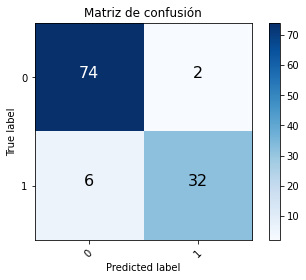

In [105]:
visualizar_confusion_matrix(y_test, modelo.predict(X_test))

Se observa un modelo balanceado en el cual, si bien hay una clase mayoritaria no duplica a la clase minoritaria.

CURVA DE ROC Y DE PRECISION-RECALL

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


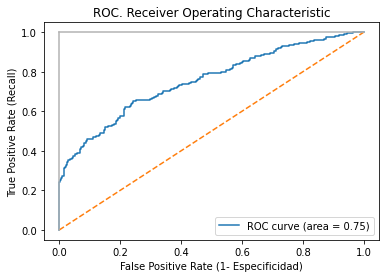

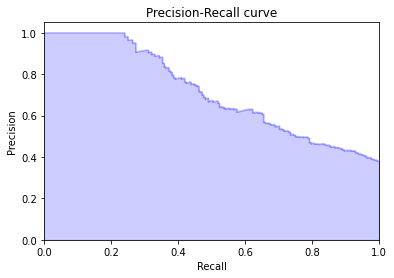

In [106]:
visualizar_curva_ROC(modelo, X, y)

En este caso, la curva de área de ROC no es tan buena como en el ejercicio anterior. El área del ROC es de un 75% por lo que el modelo sigue siendo robusto ante cambios.


El modelo siempre busca tener un True Positive Rate alto (eje Y) y un False Positive Rate bajo (eje X).

FRONTERA DE DECISIÓN DE DOS DIMENSIONES

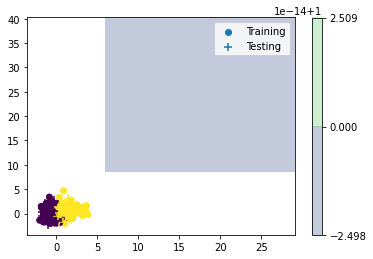

In [113]:
visualizar_frontera_de_desicion_2D(modelo, X, X_train, X_test, y_train, y_test)

FUNCION DE TRANSFERENCIA DE DOS DIMENSIONES

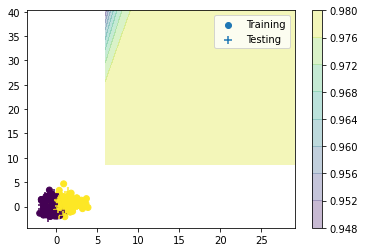

In [111]:
visualizar_funcion_transferencia_2D(modelo, X, X_train, X_test, y_train, y_test)

CURVA DE ERROR DE ENTRENAMIENTO

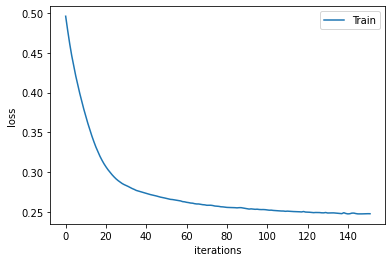

In [112]:
visualizar_curva_error_entrenamiento(modelo)